In [1]:
#Tensoreflow Magic command
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#Importing the required modules
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import pandas as pd
import cv2
import numpy as np
from glob import glob
from sklearn import preprocessing


Using TensorFlow backend.


In [3]:
#Mount the google drive 
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Copy the plant seedlings dataset from google drive to google colab local.
!cp /content/gdrive/My\ Drive/Datasets/plant-seedlings-classification.zip .

In [5]:
#Unzip the dataset
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      
  inflating: test/b4f7c9214.png      

In [6]:
#List the contents of the dataset
!ls

gdrive				    sample_data		   test
plant-seedlings-classification.zip  sample_submission.csv  train


In [0]:
#Define the Base/Train/Test folders
Base_Data_Folder = "."
Train_Data_Folder = "train"
Test_Data_Folder = "test"

In [8]:
#Loop through the folders of the train and find how many classes of the plant seedlings exist
#Store it a list call images_per_class.
images_per_class = {}
for class_folder_name in os.listdir(Train_Data_Folder):
    class_folder_path = os.path.join(Train_Data_Folder, class_folder_name)
    print(class_folder_path)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

train/Charlock
train/Charlock/d9de67550.png
train/Charlock/7066f950c.png
train/Charlock/92184e2d6.png
train/Charlock/9ae330eda.png
train/Charlock/c0aac7fc2.png
train/Charlock/7603e9dc8.png
train/Charlock/d31803377.png
train/Charlock/eeee1a97b.png
train/Charlock/f7edd4688.png
train/Charlock/adc0ca647.png
train/Charlock/84281dd7c.png
train/Charlock/a30113dfc.png
train/Charlock/1e808df13.png
train/Charlock/5db43df54.png
train/Charlock/8f4d248bd.png
train/Charlock/0537577cd.png
train/Charlock/bef36ff4f.png
train/Charlock/d0641b545.png
train/Charlock/36fad6f5d.png
train/Charlock/de1dc1b00.png
train/Charlock/09f038ce4.png
train/Charlock/6a773e6f5.png
train/Charlock/dfb3d9a79.png
train/Charlock/79e819019.png
train/Charlock/2fd604008.png
train/Charlock/c45aa7507.png
train/Charlock/78a4d13c5.png
train/Charlock/654bb174e.png
train/Charlock/ec84cacfe.png
train/Charlock/704e5bf0a.png
train/Charlock/bde26ebbb.png
train/Charlock/13d67633c.png
train/Charlock/e84b5ba79.png
train/Charlock/022179d65.png

In [9]:
#Print the number of images per class
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Charlock -> 390
Maize -> 221
Loose Silky-bent -> 654
Common wheat -> 221
Fat Hen -> 475
Scentless Mayweed -> 516
Cleavers -> 287
Sugar beet -> 385
Black-grass -> 263
Common Chickweed -> 611
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496


In [0]:
#A function definition to plot the plant seedlings images in a 6X6 format.
#Input to the function will be the class name. Totally 36 images will be displayed
def plot_for_class(label):
    nb_rows = 6
    nb_cols = 6
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(18, 18))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1 

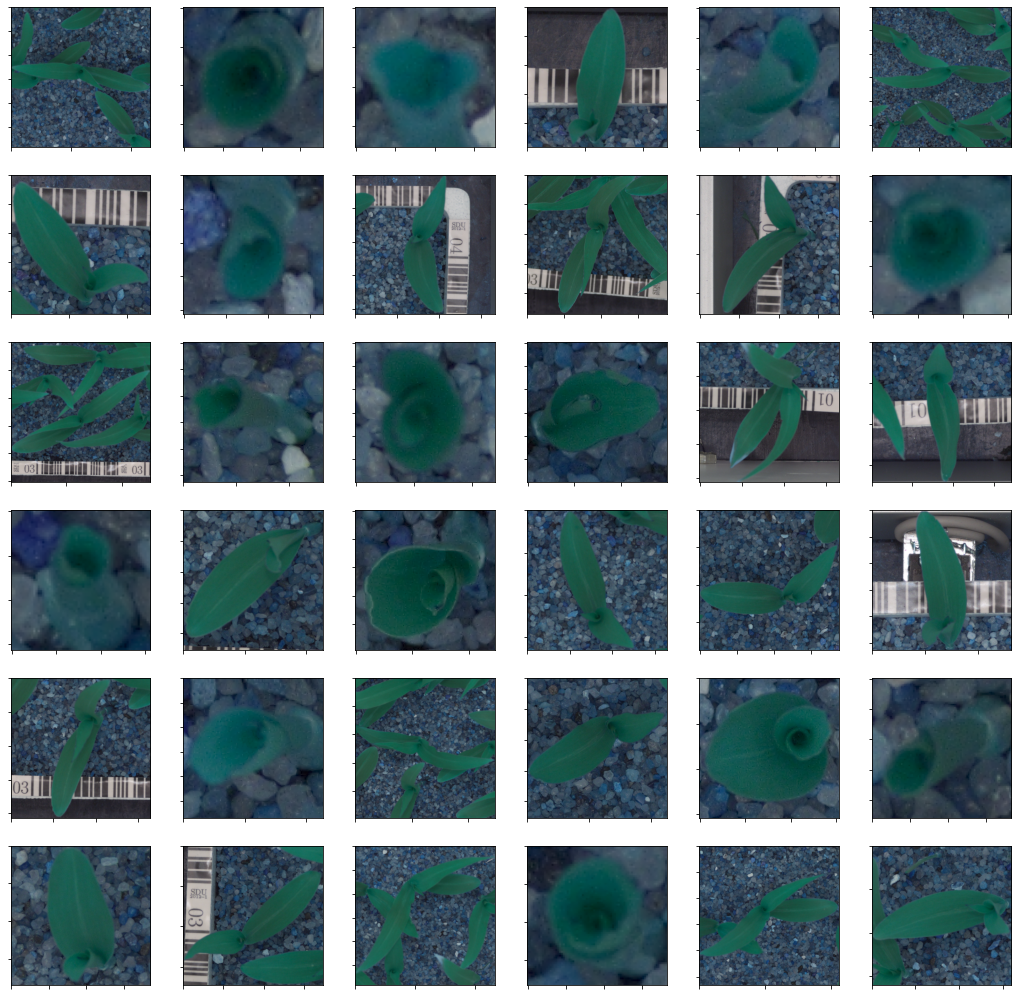

In [11]:
#Plot for the class "Maize"
plot_for_class("Maize")

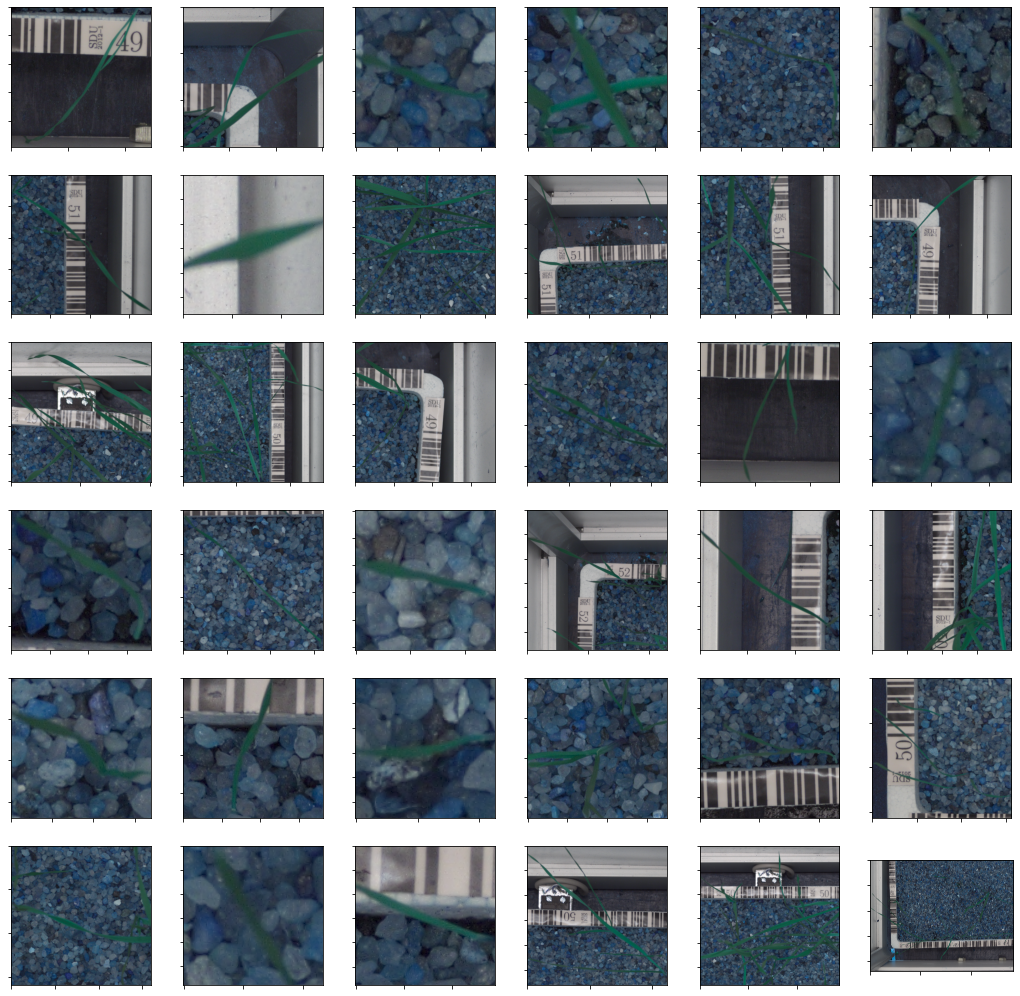

In [12]:
#Plot for the class "Black-grass"
plot_for_class("Black-grass")

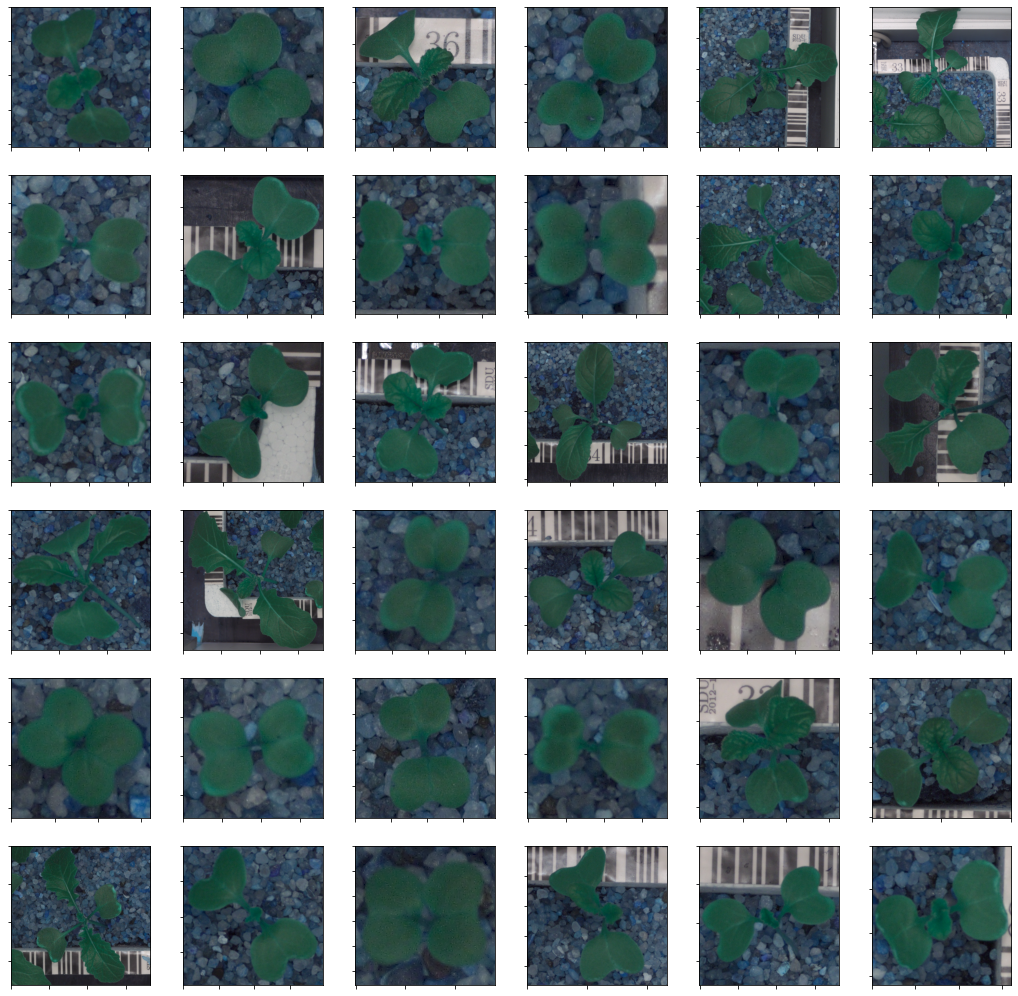

In [13]:
#Plot for the class "Charlock"
plot_for_class("Charlock")

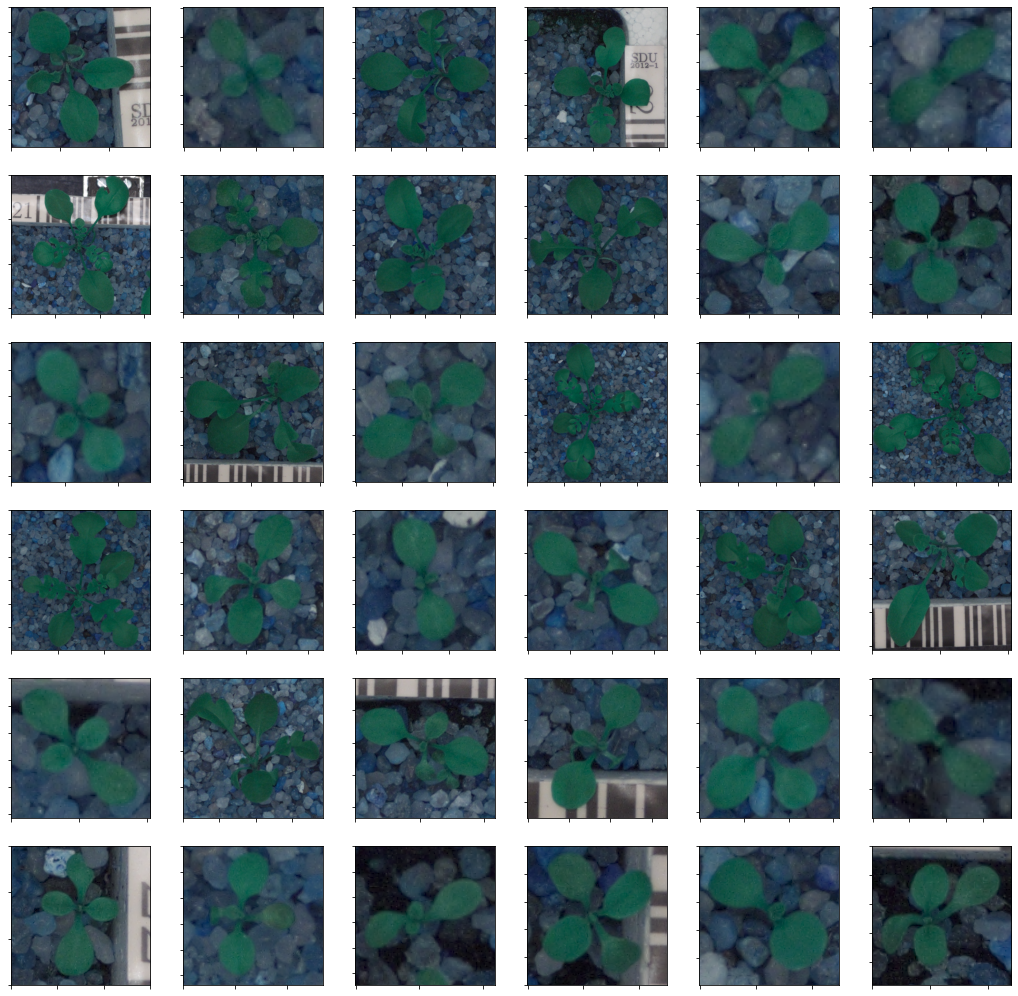

In [14]:
#Plot for the class "Shepherds Purse"
plot_for_class("Shepherds Purse")

In [15]:
#Scaling the images to a standard size
ScaleTo = 75  # px to scale
seed = 7  # fixing random

path = './train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


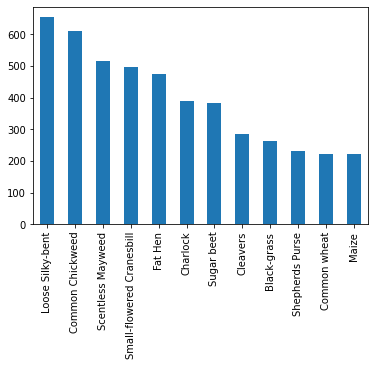

In [16]:
# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot a bar chart for number of images for each class
trainLabel[0].value_counts().plot(kind='bar')

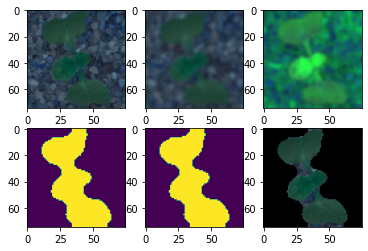

In [17]:
#Data cleansing and feature engineering, data augmentation
#Use Gaussian Blur to remove noise
#Converting BGR to HSV as it is easier to represent the color range in HSV(Hue Shift, Saturation, Value)
#Obviously since the plants are green, we can mention the lower and upper limits of the green.
#Create and apply the boolean mask to get the plants without the background.

clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)


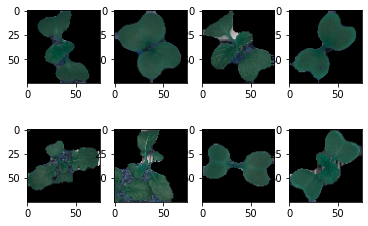

In [18]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

In [0]:
#Normalize data
clearTrainImg = clearTrainImg / 255


In [0]:
#Define some parameters
img_size = 75
img_depth = 3

In [0]:
#ImageDataGenerator declaration with 20% data as test (80% for training)
img_generator= keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               horizontal_flip=True,
                                                               validation_split=0.2)

In [0]:
#Build training generator. 
img_generator.fit(clearTrainImg)


In [23]:
#Print the shape
clearTrainImg.shape

(4750, 75, 75, 3)

In [0]:
#Training and test split
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=7, 
                                                stratify = clearTrainLabel)

In [25]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(12, activation='softmax'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Build the model
model.build()

In [28]:
#Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 71, 71, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 71, 71, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       2

In [0]:
#Saving the best model using model checkpoint callback

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_cnn.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max', 
                                                    verbose=1)

In [30]:
#Found 3803 images belonging to 12 classes.
#Found 947 images belonging to 12 classes.

#Train the model
model.fit_generator(img_generator.flow(trainX, trainY, batch_size=75), 
                    epochs=10,
                    validation_data=(testX, testY), 
                    steps_per_epoch=trainX.shape[0], 
                    callbacks=[model_checkpoint])


Epoch 1/10
 950/3800 [======>.......................] - ETA: 1s - loss: 0.2884 - acc: 0.8979
Epoch 00001: val_acc improved from -inf to 0.89789, saving model to flowers_cnn.h5
3800/3800 [==============================] - 472s 124ms/step - loss: 0.5949 - acc: 0.6506 - val_loss: 0.2925 - val_acc: 0.8979
Epoch 2/10
 900/3800 [======>.......................] - ETA: 0s - loss: 0.3549 - acc: 0.8733
Epoch 00002: val_acc did not improve from 0.89789
3800/3800 [==============================] - 441s 116ms/step - loss: 0.1805 - acc: 0.9242 - val_loss: 0.3654 - val_acc: 0.8705
Epoch 3/10
 950/3800 [======>.......................] - ETA: 0s - loss: 0.3317 - acc: 0.9074
Epoch 00003: val_acc improved from 0.89789 to 0.90737, saving model to flowers_cnn.h5
3800/3800 [==============================] - 442s 116ms/step - loss: 0.1114 - acc: 0.9552 - val_loss: 0.3334 - val_acc: 0.9074
Epoch 4/10
 900/3800 [======>.......................] - ETA: 0s - loss: 0.3059 - acc: 0.9156
Epoch 00004: val_acc improve

In [0]:
#Load the best model
model.load_weights("./flowers_cnn.h5")


In [37]:
#Evaluate the training and test accuracy

print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

3800/3800 [==============================] - 2s 402us/sample - loss: 0.0080 - acc: 0.9974
[0.008020851487021183, 0.9973684]
950/950 [==============================] - 0s 439us/sample - loss: 0.3175 - acc: 0.9305
[0.31750641623315845, 0.9305263]


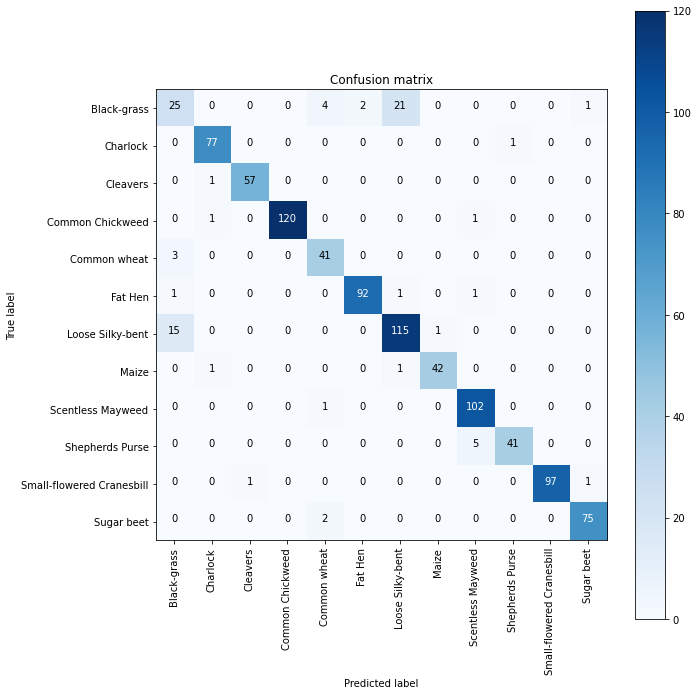

In [38]:
#Print the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_)

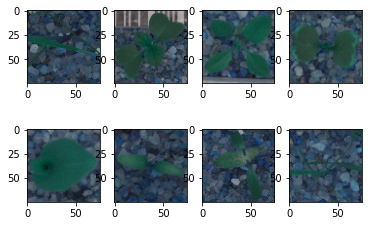

In [39]:
#Read the test folder and convert to hsv
path = './test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

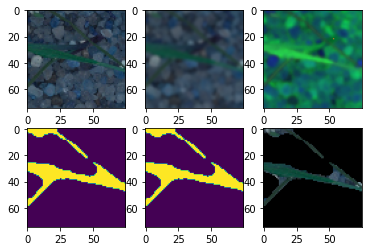

In [47]:
#Apply the filters

clearTestImg = []
examples = []; getEx = True
for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

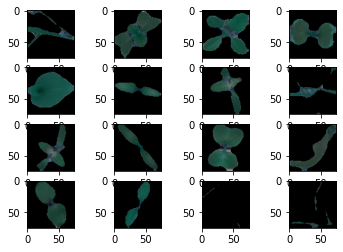

In [41]:
# Show sample result
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(clearTestImg[i])

In [0]:
clearTestImg = clearTestImg / 255

In [0]:
#Predict the results
pred = model.predict(clearTestImg)

In [0]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("./results.csv", index=False)

In [0]:
!cp results.csv /content/gdrive/My\ Drive/Datasets/